In [1]:
import numpy as np
import pandas as pd
import sys, os, glob, corner
import matplotlib.pyplot as plt
from jaxstar.utils import *

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='sans-serif')
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

In [3]:
# get rotation info
drot = pd.read_csv("mazeh+15.tsv", delimiter="|", comment="#")
drot["kepid"] = drot.KIC
prots, vars, lphs = [], [], []
for i in range(len(drot)):
    try:
        prots.append(float(drot.Prot[i]))
    except:
        prots.append(np.nan)
    try:
        vars.append(float(drot.Rvar[i]))
    except:
        vars.append(np.nan)
    try:
        lphs.append(float(drot.LPH[i]))
    except:
        lphs.append(np.nan)
drot['Prot'] = prots
drot['Rvar'] = vars
drot['LPH'] = lphs

idxm15 = (drot.F==0)&(drot.G==0)&(drot['T']==0) # False positives, Giant, Temperature
idxm15 &= (drot.C==0) & (drot.kepid!=8043882)   # written after the ACF search but Rvar/Prot were not assigined
drotm15 = drot[idxm15].reset_index(drop=True)
drot['acf'] = (drot.M1==0)&(drot.M2==0)&(drot.R==0) # robust period
print ('ACF sample: %d'%len(drotm15))
print ('Prot assigned: %d'%np.sum(drotm15.Prot==drotm15.Prot))

ACF sample: 3072
Prot assigned: 3072


In [4]:
def clean(inputfile, postdir, dsigmaobs_th=2., feh_th=0.4):
    dinput = pd.read_csv(inputfile)
    dinput["kmag"] = dinput.kmag_corrected
    dinput["kmag_err"] = dinput.kmag_err_corrected
    dinput["parallax"] = dinput.parallax_corrected
    dinput["parallax_err"] = dinput.parallax_error_corrected
    dinput["teff_err"] = 110
    dinput["feh_err"] = 0.1
    dinput["logg_err"] = 0.1
    
    dpct = summarize_results(postdir, dinput, keys, obskeys)
    fig = corner.corner(dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]], plot_contours=False)
    fig = corner.overplot_points(fig, dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]])
    
    idxgood = (dpct.dsigmaobs < dsigmaobs_th) & (np.abs(dpct.feh) < feh_th)
    dpct["idx"] = idxgood
    return dpct

def define_sample(inputfile, postdir, drot, m_min, m_max):
    dinput = pd.read_csv(inputfile)
    d = clean(inputfile, postdir)
    """ binflag vs goodness of fit
    bins = np.linspace(0, 5, 20)
    plt.hist(d.dsigmaobs[d.binflag], bins=bins, histtype='step', density=True)
    plt.hist(d.dsigmaobs[~d.binflag], bins=bins, histtype='step', density=True)
    """
    print ("# %d well-behaved stars out of %d."%(np.sum(d.idx), len(d)))
    sample_idx = d.idx & (m_min < d.iso_mass) & (d.iso_mass < m_max) 
    sample_idx_nobin = sample_idx & (~d.binflag)
    print ("# %d stars with median mass %.1f-%.1f Msun."%(np.sum(sample_idx), m_min, m_max))
    print ("# %d apparently single stars with median mass %.1f-%.1f Msun."%(np.sum(sample_idx_nobin), m_min, m_max))
    
    dsmp = d[sample_idx_nobin].reset_index(drop=True)
    fig = corner.corner(dsmp[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]], plot_contours=False)
    fig = corner.overplot_points(fig, dsmp[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]])    
    plt.suptitle("clean sample", fontsize=20)
    
    d = pd.merge(dsmp, drot[['kepid', 'acf', 'Prot', 'e_Prot', 'Rvar', 'LPH', 'w', 'D', 'N', 'C', 'G', 'T', 'F', 'R', 'M1', 'M2']])
    print ("# %d stars in final sample."%len(d))
    return d

def get_posterior_samples(d, postdir, agekey="age", n_samples=10000):
    samples = []
    for i, kepid in enumerate(d.kepid):
        filename = postdir + "%s_samples.csv"%kepid
        dp = pd.read_csv(filename)[['mass', agekey]]
        samples.append(np.array(dp)[:n_samples])
    samples = np.array(samples)
    return samples

In [5]:
obskeys = ['teff', 'feh', 'kmag', 'parallax']
keys = ['age', 'mass', 'radius'] + obskeys

In [6]:
m_min, m_max = 0.75, 1.25

In [9]:
inputfile = "../input/isoinput_cks_valid.csv"
postdir = "../posterior_samples/posteriors_cks_logage/"
name = "iso_loga_m%.2f-%.2f"%(m_min, m_max)
agekey = "logage"

# 1106 well-behaved stars out of 1202.
# 933 stars with median mass 0.8-1.2 Msun.
# 876 apparently single stars with median mass 0.8-1.2 Msun.
# 778 stars in final sample.


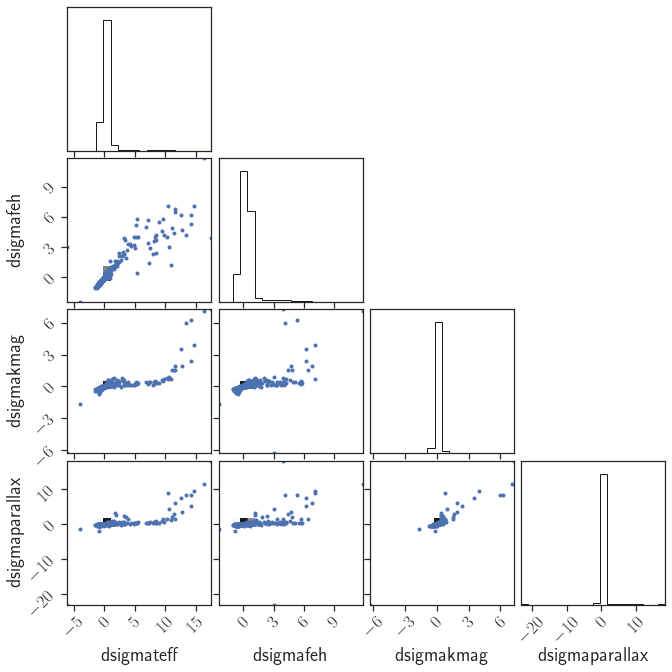

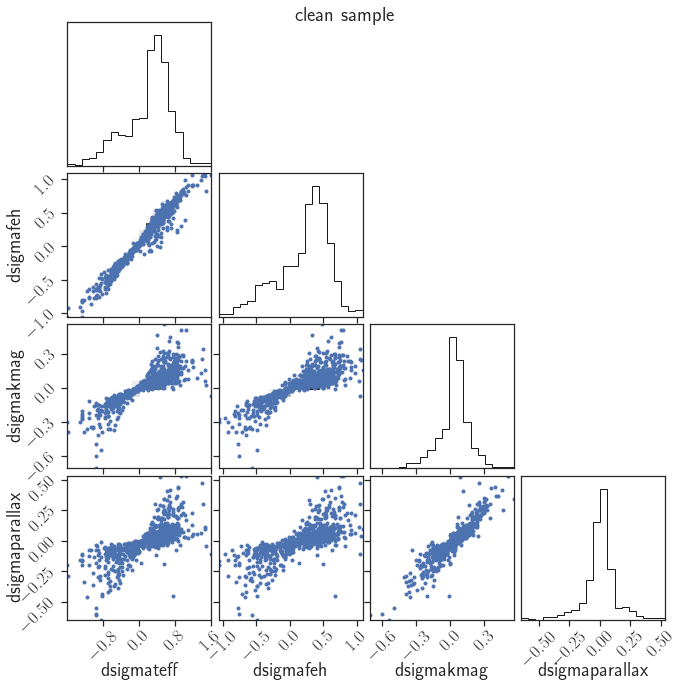

In [8]:
d = define_sample(inputfile, postdir, drot, m_min, m_max)

In [12]:
samples = get_posterior_samples(d, postdir, agekey='age')

In [13]:
d.to_csv("%s.csv"%name, index=False)
np.savez("%s.npz"%name, samples=samples)